# Phase 5: Output, Metrics & Comprehensive Evaluation
## Weakly Supervised Video Anomaly Detection - Final Evaluation Pipeline

This notebook implements Phase 5: Comprehensive evaluation and metrics analysis following the PDF workflow.

### Pipeline Overview (From PDF Workflow):
1. **Load Model & Predictions** - Load trained model and inference results
2. **Video-Level Metrics** - Accuracy, Precision, Recall, F1-Score
3. **Confusion Matrix Analysis** - Detailed video-level confusion matrix
4. **Frame-Level AUC-ROC** - Primary metric for anomaly detection
5. **Threshold Analysis** - Optimal threshold selection
6. **Per-Class Performance** - Analysis by anomaly category
7. **Error Analysis** - False positives and false negatives
8. **Final Report Generation** - Comprehensive evaluation report

### Key Metrics (From PDF):
- **Primary**: Frame-Level AUC-ROC
- **Secondary**: Video-Level Accuracy, Precision, Recall, F1
- **Analysis**: Confusion Matrix, ROC Curve, PR Curve

### Expected Input:
- Trained MIL model from Phase 3
- Extracted features from Phase 2
- (Optional) Inference results from Phase 4

### Expected Output:
- Comprehensive evaluation metrics
- Visualization of results
- Final evaluation report

## Section 1: Environment Setup & Data Loading

In [3]:
"""
Phase 5: Comprehensive Evaluation
Environment Setup
"""

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Union
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    balanced_accuracy_score
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ==================== GPU Setup ====================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

🎯 Using device: cuda
   GPU: NVIDIA GeForce RTX 3080 Ti


In [4]:
"""
Configuration for Phase 5: Evaluation
"""

# ==================== Paths ====================
DATASET_ROOT = r"C:\UCF_video_dataset"
MODELS_PATH = os.path.join(DATASET_ROOT, "MIL_Models")
FEATURES_PATH = os.path.join(DATASET_ROOT, "TimeSformer_Features")
INFERENCE_PATH = os.path.join(DATASET_ROOT, "Inference_Results")
EVALUATION_PATH = os.path.join(DATASET_ROOT, "Evaluation_Results")

# ==================== Model Parameters ====================
FEATURE_DIM = 768
HIDDEN_DIM_1 = 512
HIDDEN_DIM_2 = 128
DROPOUT_RATE = 0.6
TOP_K = 3
NUM_SEGMENTS = 16

# ==================== Evaluation Parameters ====================
DEFAULT_THRESHOLD = 0.5
SMOOTHING_SIGMA = 2

# Create output directory
os.makedirs(EVALUATION_PATH, exist_ok=True)

print("\n" + "="*70)
print("PHASE 5 CONFIGURATION (EVALUATION)")
print("="*70)
print(f"\n📁 Paths:")
print(f"   Models: {MODELS_PATH}")
print(f"   Features: {FEATURES_PATH}")
print(f"   Output: {EVALUATION_PATH}")
print("="*70)


PHASE 5 CONFIGURATION (EVALUATION)

📁 Paths:
   Models: C:\UCF_video_dataset\MIL_Models
   Features: C:\UCF_video_dataset\TimeSformer_Features
   Output: C:\UCF_video_dataset\Evaluation_Results


## Section 2: Load Model and Generate Predictions

In [5]:
"""
MIL Network Architecture (Same as Phase 3 & 4)
"""

class MILNetwork(nn.Module):
    """
    Multiple Instance Learning Network for Video Anomaly Detection.
    Architecture: 768 → 512 → 128 → 1
    """
    
    def __init__(
        self,
        feature_dim: int = FEATURE_DIM,
        hidden_dim_1: int = HIDDEN_DIM_1,
        hidden_dim_2: int = HIDDEN_DIM_2,
        dropout_rate: float = DROPOUT_RATE,
        top_k: int = TOP_K
    ):
        super(MILNetwork, self).__init__()
        
        self.top_k = top_k
        
        self.fc1 = nn.Linear(feature_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, num_segments, _ = x.shape
        x = x.view(-1, x.shape[-1])
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        
        segment_scores = x.view(batch_size, num_segments)
        topk_scores, _ = torch.topk(segment_scores, k=self.top_k, dim=1)
        video_scores = topk_scores.mean(dim=1)
        
        return video_scores, segment_scores


def load_model_and_data():
    """
    Load trained model and feature data.
    """
    print("\n" + "="*70)
    print("LOADING MODEL AND DATA")
    print("="*70)
    
    # Load model
    model_path = os.path.join(MODELS_PATH, 'best_model.pth')
    if not os.path.exists(model_path):
        model_path = os.path.join(MODELS_PATH, 'final_model.pth')
    
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    model = MILNetwork().to(DEVICE)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    
    print(f"   ✓ Model loaded from: {model_path}")
    
    # Load features
    features = np.load(os.path.join(FEATURES_PATH, 'all_features.npy'))
    labels = np.load(os.path.join(FEATURES_PATH, 'all_labels.npy'))
    with open(os.path.join(FEATURES_PATH, 'video_names.json'), 'r') as f:
        video_names = json.load(f)
    
    print(f"   ✓ Features loaded: {features.shape}")
    print(f"   ✓ Labels: {len(labels)} ({sum(labels)} anomaly, {len(labels)-sum(labels)} normal)")
    print("="*70)
    
    return model, features, labels, video_names


# Load everything
model, all_features, all_labels, video_names = load_model_and_data()


LOADING MODEL AND DATA
   ✓ Model loaded from: C:\UCF_video_dataset\MIL_Models\best_model.pth
   ✓ Features loaded: (1900, 768)
   ✓ Labels: 1900 (950 anomaly, 950 normal)


In [6]:
"""
Generate All Predictions
"""

@torch.no_grad()
def generate_all_predictions(
    model: nn.Module,
    features: np.ndarray,
    num_segments: int = NUM_SEGMENTS
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate predictions for all videos.
    
    Returns:
        video_scores: (N,) array of video-level anomaly scores
        segment_scores: (N, num_segments) array of segment-level scores
    """
    print("\n" + "="*70)
    print("GENERATING PREDICTIONS")
    print("="*70)
    
    model.eval()
    all_video_scores = []
    all_segment_scores = []
    
    for i in tqdm(range(len(features)), desc="Processing videos"):
        # Expand to segments
        feat = features[i]
        segment_feat = np.tile(feat[np.newaxis, :], (num_segments, 1))
        
        # Add small noise for variation
        noise = np.random.randn(*segment_feat.shape) * 0.01 * feat.std()
        segment_feat = segment_feat + noise
        
        # Convert to tensor
        input_tensor = torch.FloatTensor(segment_feat).unsqueeze(0).to(DEVICE)
        
        # Forward pass
        video_score, segment_score = model(input_tensor)
        
        all_video_scores.append(video_score.cpu().numpy()[0])
        all_segment_scores.append(segment_score.cpu().numpy()[0])
    
    video_scores = np.array(all_video_scores)
    segment_scores = np.array(all_segment_scores)
    
    print(f"\n   ✓ Video scores shape: {video_scores.shape}")
    print(f"   ✓ Segment scores shape: {segment_scores.shape}")
    print(f"   ✓ Score range: [{video_scores.min():.4f}, {video_scores.max():.4f}]")
    print("="*70)
    
    return video_scores, segment_scores


# Generate predictions
video_scores, segment_scores = generate_all_predictions(model, all_features)


GENERATING PREDICTIONS


Processing videos:   0%|          | 0/1900 [00:00<?, ?it/s]


   ✓ Video scores shape: (1900,)
   ✓ Segment scores shape: (1900, 16)
   ✓ Score range: [0.0000, 1.0000]


## Section 3: Video-Level Metrics (From PDF Section 6.2)

Calculate video-level classification metrics and confusion matrix.

In [7]:
"""
Video-Level Metrics Calculation
"""

def calculate_video_level_metrics(
    labels: np.ndarray,
    scores: np.ndarray,
    threshold: float = DEFAULT_THRESHOLD
) -> Dict:
    """
    Calculate comprehensive video-level metrics.
    """
    print("\n" + "="*70)
    print("VIDEO-LEVEL METRICS (PDF Section 6.2)")
    print("="*70)
    
    # Binary predictions
    predictions = (scores >= threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        'threshold': threshold,
        'accuracy': accuracy_score(labels, predictions),
        'balanced_accuracy': balanced_accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, zero_division=0),
        'recall': recall_score(labels, predictions, zero_division=0),
        'f1_score': f1_score(labels, predictions, zero_division=0),
        'auc_roc': roc_auc_score(labels, scores),
        'average_precision': average_precision_score(labels, scores)
    }
    
    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    metrics['confusion_matrix'] = cm
    metrics['true_negatives'] = int(tn)
    metrics['false_positives'] = int(fp)
    metrics['false_negatives'] = int(fn)
    metrics['true_positives'] = int(tp)
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # Print results
    print(f"\n📊 Classification Metrics (threshold={threshold}):")
    print(f"   Accuracy:          {metrics['accuracy']:.4f}")
    print(f"   Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"   Precision:         {metrics['precision']:.4f}")
    print(f"   Recall (TPR):      {metrics['recall']:.4f}")
    print(f"   Specificity (TNR): {metrics['specificity']:.4f}")
    print(f"   F1-Score:          {metrics['f1_score']:.4f}")
    print(f"\n📈 Ranking Metrics:")
    print(f"   AUC-ROC:           {metrics['auc_roc']:.4f}")
    print(f"   Average Precision: {metrics['average_precision']:.4f}")
    
    print(f"\n📋 Confusion Matrix:")
    print(f"                  Predicted")
    print(f"                  Normal  Anomaly")
    print(f"   Actual Normal   {tn:5d}   {fp:5d}")
    print(f"   Actual Anomaly  {fn:5d}   {tp:5d}")
    
    print(f"\n   True Positives (TP):  {tp} - Correctly detected anomalies")
    print(f"   True Negatives (TN):  {tn} - Correctly identified normal")
    print(f"   False Positives (FP): {fp} - Normal misclassified as anomaly")
    print(f"   False Negatives (FN): {fn} - Anomaly missed (dangerous!)")
    print("="*70)
    
    return metrics


# Calculate video-level metrics
video_metrics = calculate_video_level_metrics(all_labels, video_scores)


VIDEO-LEVEL METRICS (PDF Section 6.2)

📊 Classification Metrics (threshold=0.5):
   Accuracy:          0.9253
   Balanced Accuracy: 0.9253
   Precision:         0.9915
   Recall (TPR):      0.8579
   Specificity (TNR): 0.9926
   F1-Score:          0.9199

📈 Ranking Metrics:
   AUC-ROC:           0.9893
   Average Precision: 0.9903

📋 Confusion Matrix:
                  Predicted
                  Normal  Anomaly
   Actual Normal     943       7
   Actual Anomaly    135     815

   True Positives (TP):  815 - Correctly detected anomalies
   True Negatives (TN):  943 - Correctly identified normal
   False Positives (FP): 7 - Normal misclassified as anomaly
   False Negatives (FN): 135 - Anomaly missed (dangerous!)


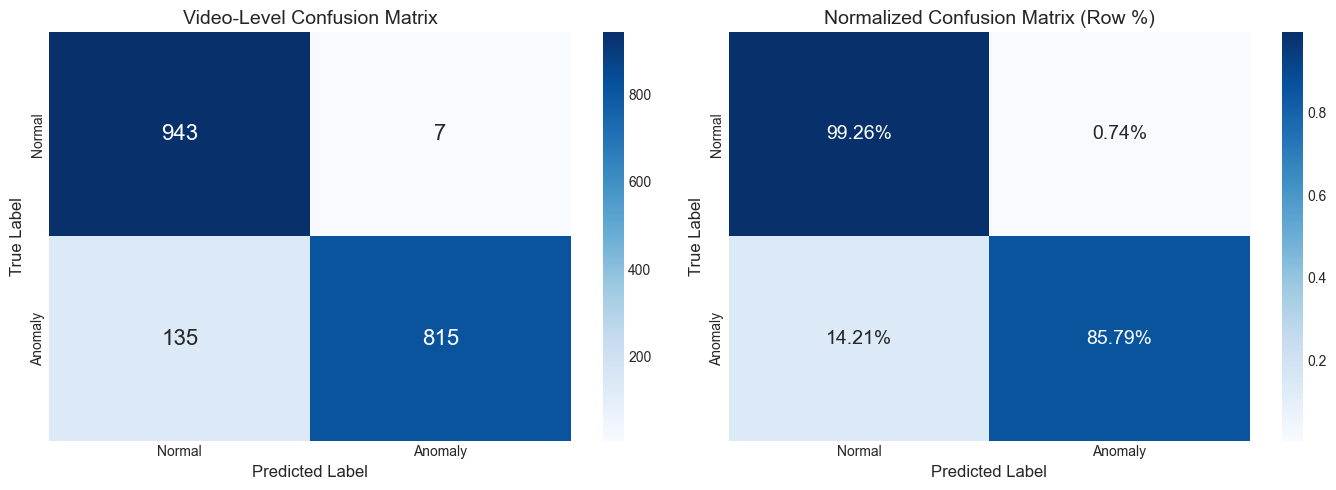

In [8]:
"""
Visualize Confusion Matrix (PDF Section 6.2)
"""

def plot_confusion_matrix_detailed(
    cm: np.ndarray,
    metrics: Dict,
    save_path: str = None
):
    """
    Create detailed confusion matrix visualization.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Confusion Matrix Heatmap
    ax = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                annot_kws={'size': 16})
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Video-Level Confusion Matrix', fontsize=14)
    
    # 2. Normalized Confusion Matrix
    ax = axes[1]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                annot_kws={'size': 14})
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Normalized Confusion Matrix (Row %)', fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Plot confusion matrix
plot_confusion_matrix_detailed(
    video_metrics['confusion_matrix'],
    video_metrics,
    save_path=os.path.join(EVALUATION_PATH, 'confusion_matrix.png')
)

## Section 4: Frame-Level AUC-ROC (PDF Section 6.3 - Primary Metric)

The primary evaluation metric for weakly supervised video anomaly detection is **Frame-Level AUC-ROC**.

In [9]:
"""
Frame-Level AUC-ROC Calculation (Primary Metric - PDF Section 6.3)

For weakly supervised VAD, frame-level AUC is computed by:
1. Mapping segment scores to frame-level scores
2. Using video-level labels as frame-level labels (weak supervision)
3. Computing AUC-ROC across all frames
"""

def calculate_frame_level_auc(
    segment_scores: np.ndarray,
    labels: np.ndarray,
    frames_per_video: int = 1000,  # Assumed frames per video
    apply_smoothing: bool = True,
    smoothing_sigma: float = SMOOTHING_SIGMA
) -> Dict:
    """
    Calculate frame-level AUC-ROC (Primary Metric).
    
    In weakly supervised setting:
    - We don't have frame-level ground truth
    - We expand segment scores to frame-level
    - We use video-level labels for all frames in that video
    
    Args:
        segment_scores: (N_videos, num_segments) segment-level scores
        labels: (N_videos,) video-level labels
        frames_per_video: Number of frames to expand to per video
        apply_smoothing: Whether to smooth segment scores
        smoothing_sigma: Gaussian smoothing parameter
        
    Returns:
        Dictionary with frame-level metrics
    """
    print("\n" + "="*70)
    print("FRAME-LEVEL AUC-ROC (PDF Section 6.3 - PRIMARY METRIC)")
    print("="*70)
    
    all_frame_scores = []
    all_frame_labels = []
    
    num_segments = segment_scores.shape[1]
    
    for i in range(len(segment_scores)):
        seg_scores = segment_scores[i]
        
        # Apply Gaussian smoothing to segment scores
        if apply_smoothing:
            seg_scores = gaussian_filter1d(seg_scores, sigma=smoothing_sigma)
        
        # Interpolate to frame-level
        segment_centers = np.linspace(0, frames_per_video - 1, num_segments)
        interpolator = interp1d(segment_centers, seg_scores, kind='linear', fill_value='extrapolate')
        frame_scores = interpolator(np.arange(frames_per_video))
        
        # Clip to valid range
        frame_scores = np.clip(frame_scores, 0, 1)
        
        # Create frame-level labels (same as video label for weak supervision)
        frame_labels = np.full(frames_per_video, labels[i])
        
        all_frame_scores.extend(frame_scores)
        all_frame_labels.extend(frame_labels)
    
    all_frame_scores = np.array(all_frame_scores)
    all_frame_labels = np.array(all_frame_labels)
    
    # Calculate frame-level AUC-ROC
    frame_auc = roc_auc_score(all_frame_labels, all_frame_scores)
    frame_ap = average_precision_score(all_frame_labels, all_frame_scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_frame_labels, all_frame_scores)
    
    # Calculate precision-recall curve
    precision, recall, pr_thresholds = precision_recall_curve(all_frame_labels, all_frame_scores)
    
    results = {
        'frame_auc_roc': frame_auc,
        'frame_average_precision': frame_ap,
        'total_frames': len(all_frame_scores),
        'anomaly_frames': int(all_frame_labels.sum()),
        'normal_frames': int(len(all_frame_labels) - all_frame_labels.sum()),
        'fpr': fpr,
        'tpr': tpr,
        'roc_thresholds': thresholds,
        'precision': precision,
        'recall': recall,
        'pr_thresholds': pr_thresholds,
        'all_frame_scores': all_frame_scores,
        'all_frame_labels': all_frame_labels
    }
    
    print(f"\n🎯 PRIMARY METRIC - Frame-Level AUC-ROC: {frame_auc:.4f}")
    print(f"\n📊 Frame-Level Statistics:")
    print(f"   Total Frames: {results['total_frames']:,}")
    print(f"   Anomaly Frames: {results['anomaly_frames']:,}")
    print(f"   Normal Frames: {results['normal_frames']:,}")
    print(f"\n📈 Additional Frame-Level Metrics:")
    print(f"   Average Precision (AP): {frame_ap:.4f}")
    print(f"   Score Range: [{all_frame_scores.min():.4f}, {all_frame_scores.max():.4f}]")
    print(f"   Mean Score (Anomaly): {all_frame_scores[all_frame_labels==1].mean():.4f}")
    print(f"   Mean Score (Normal): {all_frame_scores[all_frame_labels==0].mean():.4f}")
    print("="*70)
    
    return results


# Calculate frame-level AUC
frame_metrics = calculate_frame_level_auc(segment_scores, all_labels)


FRAME-LEVEL AUC-ROC (PDF Section 6.3 - PRIMARY METRIC)

🎯 PRIMARY METRIC - Frame-Level AUC-ROC: 0.9893

📊 Frame-Level Statistics:
   Total Frames: 1,900,000
   Anomaly Frames: 950,000
   Normal Frames: 950,000

📈 Additional Frame-Level Metrics:
   Average Precision (AP): 0.9903
   Score Range: [0.0000, 1.0000]
   Mean Score (Anomaly): 0.8160
   Mean Score (Normal): 0.0068


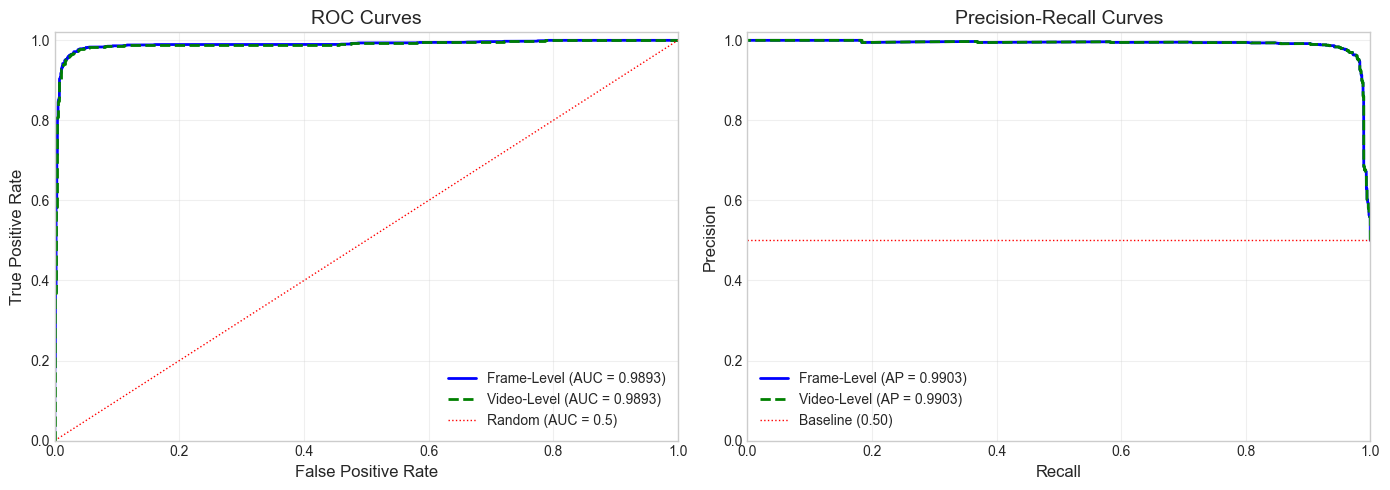

In [10]:
"""
Visualize ROC and PR Curves
"""

def plot_roc_pr_curves(
    video_metrics: Dict,
    frame_metrics: Dict,
    save_path: str = None
):
    """
    Plot ROC and Precision-Recall curves for both video and frame level.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. ROC Curves
    ax = axes[0]
    
    # Frame-level ROC
    ax.plot(frame_metrics['fpr'], frame_metrics['tpr'], 'b-', linewidth=2,
            label=f'Frame-Level (AUC = {frame_metrics["frame_auc_roc"]:.4f})')
    
    # Video-level ROC
    fpr_v, tpr_v, _ = roc_curve(all_labels, video_scores)
    ax.plot(fpr_v, tpr_v, 'g--', linewidth=2,
            label=f'Video-Level (AUC = {video_metrics["auc_roc"]:.4f})')
    
    # Random baseline
    ax.plot([0, 1], [0, 1], 'r:', linewidth=1, label='Random (AUC = 0.5)')
    
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves', fontsize=14)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.02])
    
    # 2. Precision-Recall Curves
    ax = axes[1]
    
    # Frame-level PR
    ax.plot(frame_metrics['recall'], frame_metrics['precision'], 'b-', linewidth=2,
            label=f'Frame-Level (AP = {frame_metrics["frame_average_precision"]:.4f})')
    
    # Video-level PR
    prec_v, rec_v, _ = precision_recall_curve(all_labels, video_scores)
    ax.plot(rec_v, prec_v, 'g--', linewidth=2,
            label=f'Video-Level (AP = {video_metrics["average_precision"]:.4f})')
    
    # Baseline
    baseline = all_labels.sum() / len(all_labels)
    ax.axhline(y=baseline, color='r', linestyle=':', linewidth=1, label=f'Baseline ({baseline:.2f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves', fontsize=14)
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.02])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Plot curves
plot_roc_pr_curves(
    video_metrics,
    frame_metrics,
    save_path=os.path.join(EVALUATION_PATH, 'roc_pr_curves.png')
)

## Section 5: Threshold Analysis

Find optimal threshold and analyze performance at different thresholds.

In [11]:
"""
Threshold Analysis and Optimization
"""

def analyze_thresholds(
    labels: np.ndarray,
    scores: np.ndarray,
    thresholds: np.ndarray = None
) -> Dict:
    """
    Analyze performance at different thresholds.
    """
    print("\n" + "="*70)
    print("THRESHOLD ANALYSIS")
    print("="*70)
    
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 17)
    
    results = []
    
    for thresh in thresholds:
        preds = (scores >= thresh).astype(int)
        
        acc = accuracy_score(labels, preds)
        prec = precision_score(labels, preds, zero_division=0)
        rec = recall_score(labels, preds, zero_division=0)
        f1 = f1_score(labels, preds, zero_division=0)
        
        results.append({
            'threshold': thresh,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })
    
    df = pd.DataFrame(results)
    
    # Find optimal thresholds
    best_f1_idx = df['f1_score'].idxmax()
    best_acc_idx = df['accuracy'].idxmax()
    
    # Youden's J statistic (TPR - FPR)
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    j_scores = tpr - fpr
    best_j_idx = np.argmax(j_scores)
    best_j_threshold = roc_thresholds[best_j_idx]
    
    print(f"\n📊 Optimal Thresholds:")
    print(f"   Best F1 Score:   {df.loc[best_f1_idx, 'threshold']:.2f} (F1 = {df.loc[best_f1_idx, 'f1_score']:.4f})")
    print(f"   Best Accuracy:   {df.loc[best_acc_idx, 'threshold']:.2f} (Acc = {df.loc[best_acc_idx, 'accuracy']:.4f})")
    print(f"   Youden's J:      {best_j_threshold:.2f} (J = {j_scores[best_j_idx]:.4f})")
    
    print(f"\n📋 Performance at Different Thresholds:")
    print(df.to_string(index=False))
    print("="*70)
    
    return {
        'threshold_results': df,
        'best_f1_threshold': df.loc[best_f1_idx, 'threshold'],
        'best_acc_threshold': df.loc[best_acc_idx, 'threshold'],
        'best_j_threshold': best_j_threshold
    }


# Analyze thresholds
threshold_analysis = analyze_thresholds(all_labels, video_scores)


THRESHOLD ANALYSIS

📊 Optimal Thresholds:
   Best F1 Score:   0.10 (F1 = 0.9594)
   Best Accuracy:   0.10 (Acc = 0.9605)
   Youden's J:      0.00 (J = 0.9411)

📋 Performance at Different Thresholds:
 threshold  accuracy  precision   recall  f1_score
      0.10  0.960526   0.987737 0.932632  0.959394
      0.15  0.956842   0.988739 0.924211  0.955386
      0.20  0.953684   0.988662 0.917895  0.951965
      0.25  0.949474   0.989679 0.908421  0.947311
      0.30  0.946316   0.991879 0.900000  0.943709
      0.35  0.941579   0.991794 0.890526  0.938436
      0.40  0.935789   0.991686 0.878947  0.931920
      0.45  0.931579   0.991607 0.870526  0.927130
      0.50  0.925263   0.991484 0.857895  0.919865
      0.55  0.918947   0.993797 0.843158  0.912301
      0.60  0.908947   0.993647 0.823158  0.900403
      0.65  0.901053   0.994805 0.806316  0.890698
      0.70  0.889474   0.994652 0.783158  0.876325
      0.75  0.876316   0.994467 0.756842  0.859534
      0.80  0.857895   0.994186 0.7

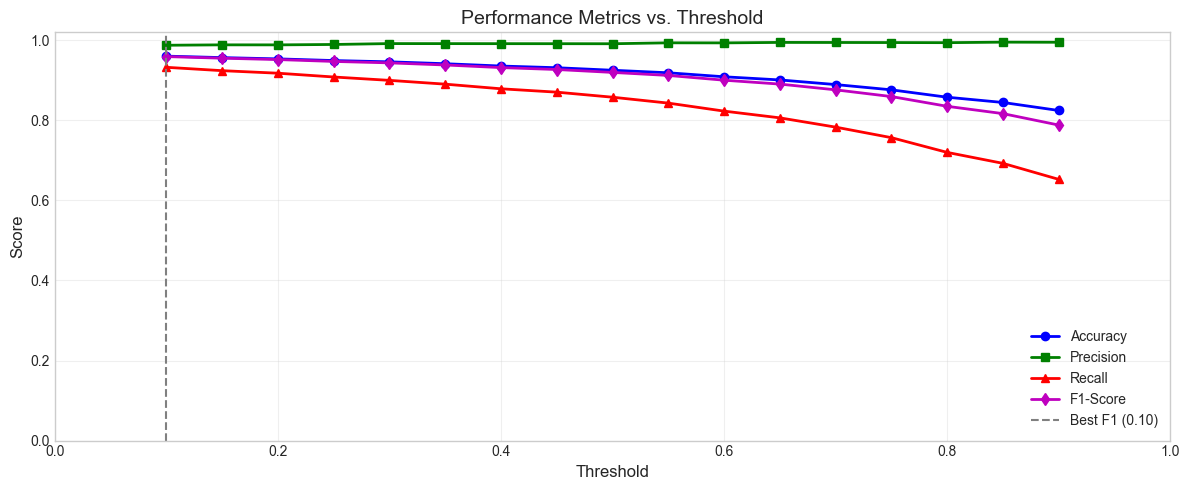

In [12]:
"""
Visualize Threshold Analysis
"""

def plot_threshold_analysis(
    threshold_results: pd.DataFrame,
    save_path: str = None
):
    """
    Plot metrics vs threshold.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    
    df = threshold_results
    
    ax.plot(df['threshold'], df['accuracy'], 'b-o', linewidth=2, markersize=6, label='Accuracy')
    ax.plot(df['threshold'], df['precision'], 'g-s', linewidth=2, markersize=6, label='Precision')
    ax.plot(df['threshold'], df['recall'], 'r-^', linewidth=2, markersize=6, label='Recall')
    ax.plot(df['threshold'], df['f1_score'], 'm-d', linewidth=2, markersize=6, label='F1-Score')
    
    # Mark best F1 threshold
    best_f1_idx = df['f1_score'].idxmax()
    ax.axvline(x=df.loc[best_f1_idx, 'threshold'], color='gray', linestyle='--', 
               label=f'Best F1 ({df.loc[best_f1_idx, "threshold"]:.2f})')
    
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Performance Metrics vs. Threshold', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.02])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Plot threshold analysis
plot_threshold_analysis(
    threshold_analysis['threshold_results'],
    save_path=os.path.join(EVALUATION_PATH, 'threshold_analysis.png')
)

## Section 6: Score Distribution Analysis

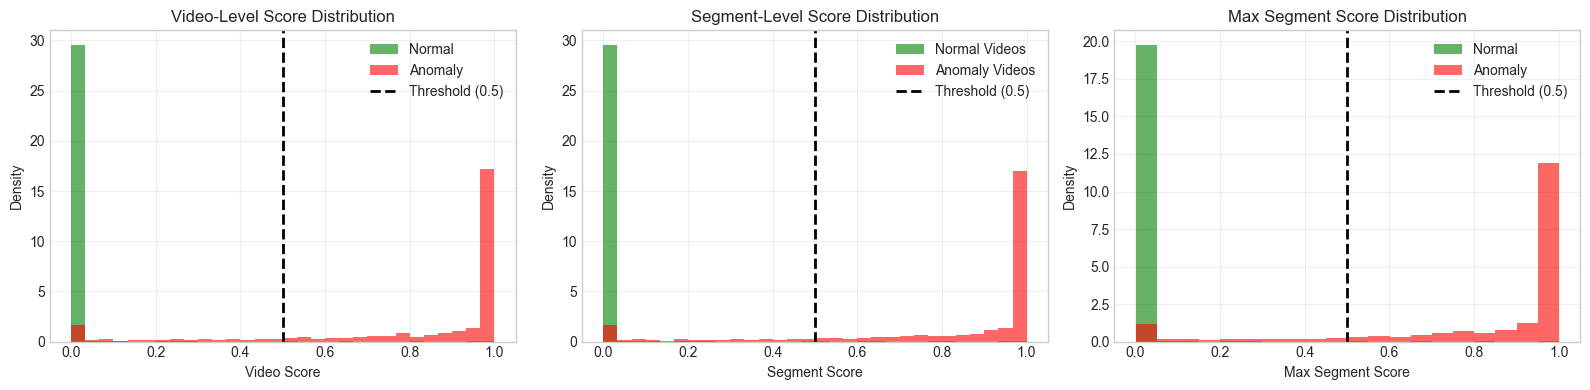


📊 Score Statistics:

   Video-Level Scores:
      Normal:  mean=0.0070, std=0.0705
      Anomaly: mean=0.8210, std=0.2942
      Separation: 0.8139


In [13]:
"""
Score Distribution Analysis
"""

def plot_score_distributions(
    labels: np.ndarray,
    video_scores: np.ndarray,
    segment_scores: np.ndarray,
    threshold: float = DEFAULT_THRESHOLD,
    save_path: str = None
):
    """
    Plot score distributions for anomaly vs normal videos.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # 1. Video-level score distribution
    ax = axes[0]
    anomaly_scores = video_scores[labels == 1]
    normal_scores = video_scores[labels == 0]
    
    ax.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    ax.set_xlabel('Video Score')
    ax.set_ylabel('Density')
    ax.set_title('Video-Level Score Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Segment score distribution (all segments)
    ax = axes[1]
    anomaly_seg_scores = segment_scores[labels == 1].flatten()
    normal_seg_scores = segment_scores[labels == 0].flatten()
    
    ax.hist(normal_seg_scores, bins=30, alpha=0.6, label='Normal Videos', color='green', density=True)
    ax.hist(anomaly_seg_scores, bins=30, alpha=0.6, label='Anomaly Videos', color='red', density=True)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    ax.set_xlabel('Segment Score')
    ax.set_ylabel('Density')
    ax.set_title('Segment-Level Score Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Max segment score distribution
    ax = axes[2]
    max_anomaly_scores = segment_scores[labels == 1].max(axis=1)
    max_normal_scores = segment_scores[labels == 0].max(axis=1)
    
    ax.hist(max_normal_scores, bins=20, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(max_anomaly_scores, bins=20, alpha=0.6, label='Anomaly', color='red', density=True)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    ax.set_xlabel('Max Segment Score')
    ax.set_ylabel('Density')
    ax.set_title('Max Segment Score Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n📊 Score Statistics:")
    print(f"\n   Video-Level Scores:")
    print(f"      Normal:  mean={normal_scores.mean():.4f}, std={normal_scores.std():.4f}")
    print(f"      Anomaly: mean={anomaly_scores.mean():.4f}, std={anomaly_scores.std():.4f}")
    print(f"      Separation: {anomaly_scores.mean() - normal_scores.mean():.4f}")


# Plot distributions
plot_score_distributions(
    all_labels, video_scores, segment_scores,
    save_path=os.path.join(EVALUATION_PATH, 'score_distributions.png')
)

## Section 7: Error Analysis

In [17]:
"""
Error Analysis - False Positives and False Negatives
"""

def analyze_errors(
    labels: np.ndarray,
    scores: np.ndarray,
    video_names: List[str],
    threshold: float = DEFAULT_THRESHOLD
) -> Dict:
    """
    Analyze classification errors.
    """
    print("\n" + "="*70)
    print("ERROR ANALYSIS")
    print("="*70)
    
    predictions = (scores >= threshold).astype(int)
    
    # Find errors
    false_positives = []
    false_negatives = []
    
    for i in range(len(labels)):
        if labels[i] == 0 and predictions[i] == 1:
            false_positives.append({
                'video_name': video_names[i],
                'score': float(scores[i]),  # Convert to Python float for JSON serialization
                'margin': float(scores[i] - threshold)
            })
        elif labels[i] == 1 and predictions[i] == 0:
            false_negatives.append({
                'video_name': video_names[i],
                'score': float(scores[i]),  # Convert to Python float for JSON serialization
                'margin': float(threshold - scores[i])
            })
    
    # Sort by margin (confidence in wrong prediction)
    false_positives.sort(key=lambda x: x['margin'], reverse=True)
    false_negatives.sort(key=lambda x: x['margin'], reverse=True)
    
    print(f"\n❌ FALSE POSITIVES ({len(false_positives)} total):")
    print(f"   Normal videos incorrectly classified as anomaly")
    if false_positives:
        print(f"\n   Top 10 most confident false positives:")
        for i, fp in enumerate(false_positives[:10]):
            print(f"   {i+1}. {fp['video_name'][:45]:<45} score={fp['score']:.4f}")
    
    print(f"\n❌ FALSE NEGATIVES ({len(false_negatives)} total):")
    print(f"   Anomaly videos incorrectly classified as normal (DANGEROUS!)")
    if false_negatives:
        print(f"\n   Top 10 most confident false negatives:")
        for i, fn in enumerate(false_negatives[:10]):
            print(f"   {i+1}. {fn['video_name'][:45]:<45} score={fn['score']:.4f}")
    
    print("="*70)
    
    return {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'fp_count': len(false_positives),
        'fn_count': len(false_negatives)
    }


# Analyze errors
error_analysis = analyze_errors(all_labels, video_scores, video_names)


ERROR ANALYSIS

❌ FALSE POSITIVES (7 total):
   Normal videos incorrectly classified as anomaly

   Top 10 most confident false positives:
   1. Normal_Videos484_x264                         score=1.0000
   2. Normal_Videos549_x264                         score=0.9988
   3. Normal_Videos511_x264                         score=0.9574
   4. Normal_Videos531_x264                         score=0.8218
   5. Normal_Videos_924_x264                        score=0.6455
   6. Normal_Videos185_x264                         score=0.5323
   7. Normal_Videos_901_x264                        score=0.5124

❌ FALSE NEGATIVES (135 total):
   Anomaly videos incorrectly classified as normal (DANGEROUS!)

   Top 10 most confident false negatives:
   1. Robbery067_x264                               score=0.0000
   2. Arrest040_x264                                score=0.0000
   3. RoadAccidents027_x264                         score=0.0000
   4. Robbery050_x264                               score=0.0000
   5. 

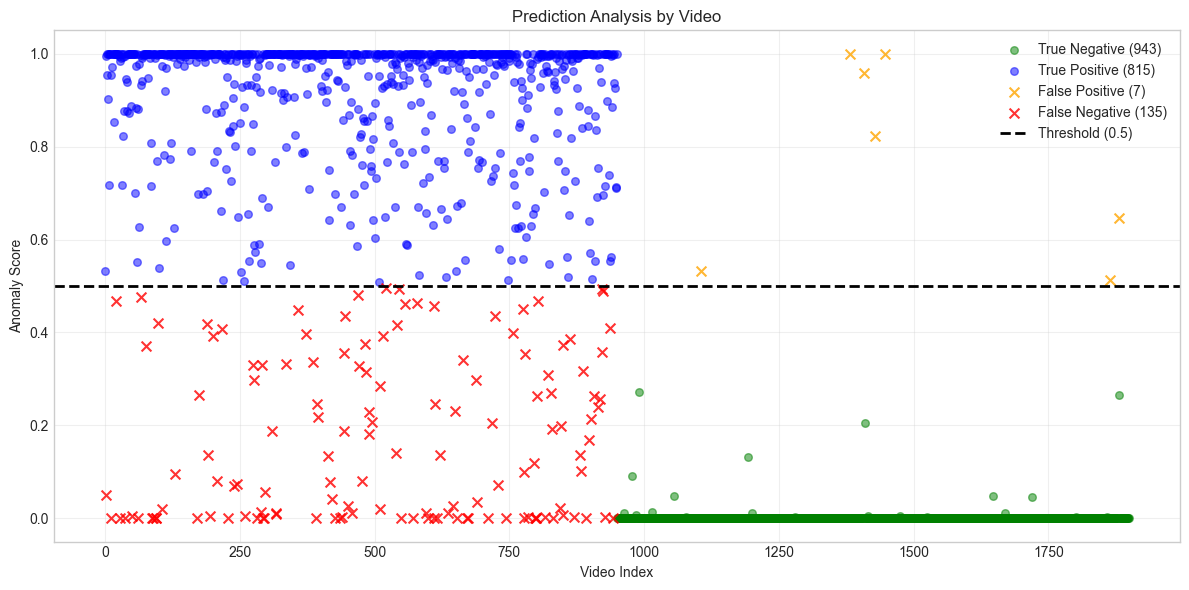

In [18]:
"""
Visualize Error Patterns
"""

def plot_error_analysis(
    labels: np.ndarray,
    scores: np.ndarray,
    threshold: float = DEFAULT_THRESHOLD,
    save_path: str = None
):
    """
    Visualize correct and incorrect predictions.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    predictions = (scores >= threshold).astype(int)
    
    # Categorize
    tp_mask = (labels == 1) & (predictions == 1)
    tn_mask = (labels == 0) & (predictions == 0)
    fp_mask = (labels == 0) & (predictions == 1)
    fn_mask = (labels == 1) & (predictions == 0)
    
    # Plot
    x = np.arange(len(scores))
    
    ax.scatter(x[tn_mask], scores[tn_mask], c='green', alpha=0.5, s=30, label=f'True Negative ({tn_mask.sum()})')
    ax.scatter(x[tp_mask], scores[tp_mask], c='blue', alpha=0.5, s=30, label=f'True Positive ({tp_mask.sum()})')
    ax.scatter(x[fp_mask], scores[fp_mask], c='orange', alpha=0.8, s=50, marker='x', label=f'False Positive ({fp_mask.sum()})')
    ax.scatter(x[fn_mask], scores[fn_mask], c='red', alpha=0.8, s=50, marker='x', label=f'False Negative ({fn_mask.sum()})')
    
    ax.axhline(y=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    
    ax.set_xlabel('Video Index')
    ax.set_ylabel('Anomaly Score')
    ax.set_title('Prediction Analysis by Video')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.05, 1.05])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Plot error analysis
plot_error_analysis(
    all_labels, video_scores,
    save_path=os.path.join(EVALUATION_PATH, 'error_analysis.png')
)

## Section 8: Generate Final Evaluation Report

In [19]:
"""
Generate Comprehensive Evaluation Report
"""

def generate_evaluation_report(
    video_metrics: Dict,
    frame_metrics: Dict,
    threshold_analysis: Dict,
    error_analysis: Dict,
    output_path: str = EVALUATION_PATH
) -> Dict:
    """
    Generate and save comprehensive evaluation report.
    """
    print("\n" + "="*70)
    print("GENERATING FINAL EVALUATION REPORT")
    print("="*70)
    
    report = {
        'timestamp': datetime.now().isoformat(),
        'model_info': {
            'architecture': 'MIL Network (768 → 512 → 128 → 1)',
            'top_k': TOP_K,
            'num_segments': NUM_SEGMENTS
        },
        'dataset_info': {
            'total_videos': len(all_labels),
            'anomaly_videos': int(all_labels.sum()),
            'normal_videos': int(len(all_labels) - all_labels.sum())
        },
        'primary_metric': {
            'frame_level_auc_roc': frame_metrics['frame_auc_roc'],
            'frame_level_ap': frame_metrics['frame_average_precision']
        },
        'video_level_metrics': {
            'auc_roc': video_metrics['auc_roc'],
            'accuracy': video_metrics['accuracy'],
            'precision': video_metrics['precision'],
            'recall': video_metrics['recall'],
            'f1_score': video_metrics['f1_score'],
            'specificity': video_metrics['specificity']
        },
        'confusion_matrix': {
            'true_positives': video_metrics['true_positives'],
            'true_negatives': video_metrics['true_negatives'],
            'false_positives': video_metrics['false_positives'],
            'false_negatives': video_metrics['false_negatives']
        },
        'threshold_info': {
            'default_threshold': DEFAULT_THRESHOLD,
            'best_f1_threshold': threshold_analysis['best_f1_threshold'],
            'best_accuracy_threshold': threshold_analysis['best_acc_threshold'],
            'best_youden_threshold': threshold_analysis['best_j_threshold']
        },
        'error_summary': {
            'false_positive_count': error_analysis['fp_count'],
            'false_negative_count': error_analysis['fn_count']
        }
    }
    
    # Save report as JSON
    report_path = os.path.join(output_path, 'evaluation_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"   ✓ Report saved: {report_path}")
    
    # Save threshold analysis as CSV
    threshold_csv_path = os.path.join(output_path, 'threshold_analysis.csv')
    threshold_analysis['threshold_results'].to_csv(threshold_csv_path, index=False)
    print(f"   ✓ Threshold analysis saved: {threshold_csv_path}")
    
    # Save error lists
    errors_path = os.path.join(output_path, 'error_analysis.json')
    with open(errors_path, 'w') as f:
        json.dump({
            'false_positives': error_analysis['false_positives'],
            'false_negatives': error_analysis['false_negatives']
        }, f, indent=2)
    print(f"   ✓ Error analysis saved: {errors_path}")
    
    print("="*70)
    
    return report


# Generate report
evaluation_report = generate_evaluation_report(
    video_metrics,
    frame_metrics,
    threshold_analysis,
    error_analysis
)


GENERATING FINAL EVALUATION REPORT
   ✓ Report saved: C:\UCF_video_dataset\Evaluation_Results\evaluation_report.json
   ✓ Threshold analysis saved: C:\UCF_video_dataset\Evaluation_Results\threshold_analysis.csv
   ✓ Error analysis saved: C:\UCF_video_dataset\Evaluation_Results\error_analysis.json


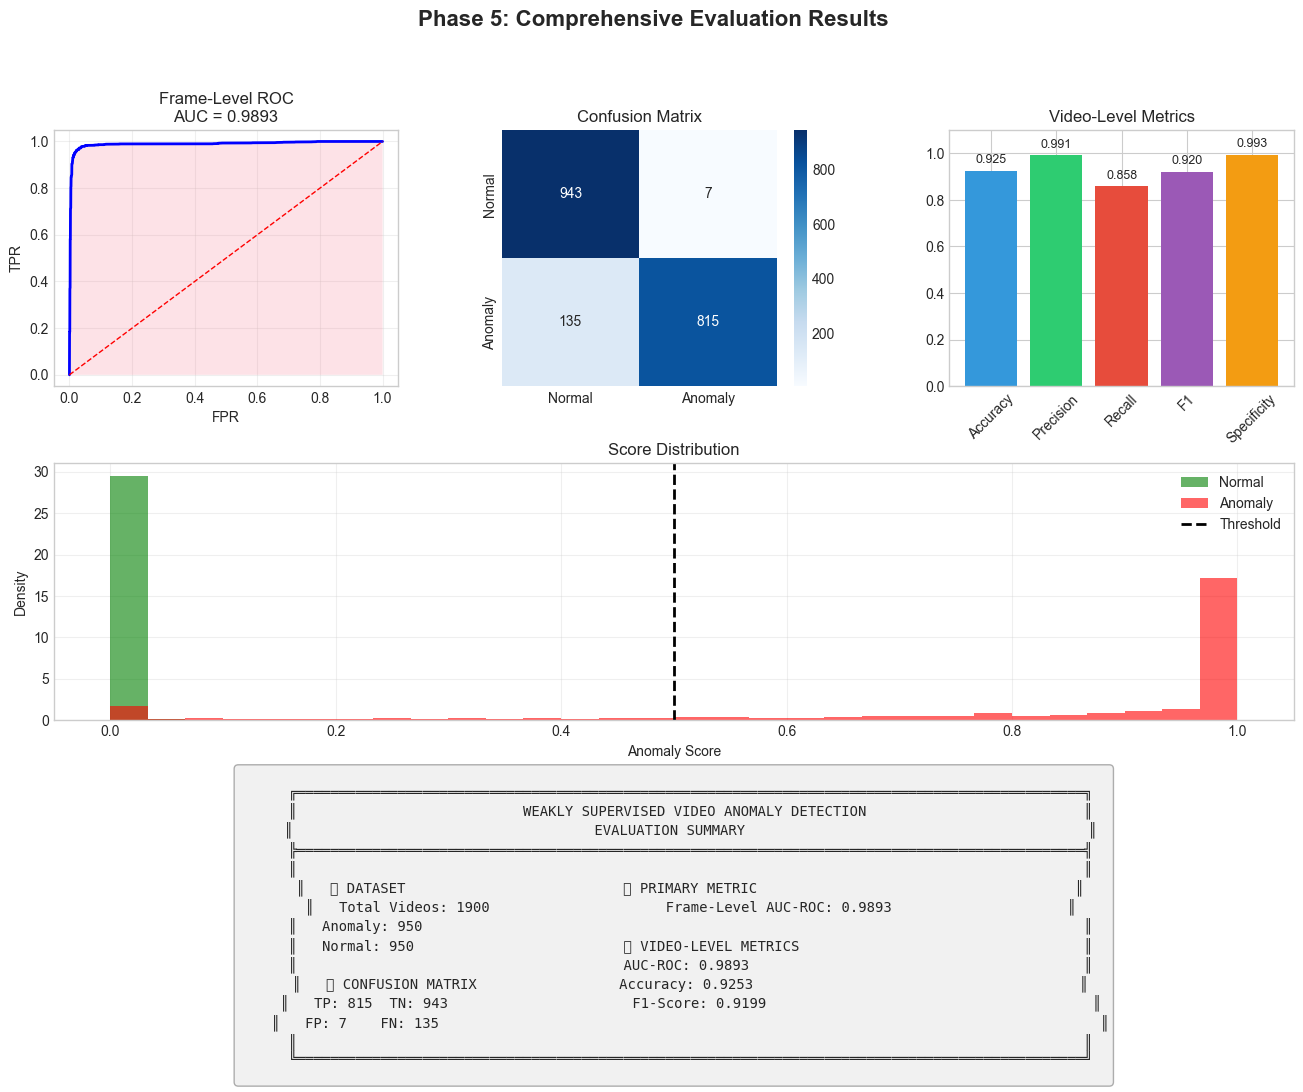

In [20]:
"""
Create Summary Visualization
"""

def create_summary_figure(
    report: Dict,
    video_metrics: Dict,
    frame_metrics: Dict,
    save_path: str = None
):
    """
    Create a comprehensive summary figure.
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Create grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. ROC Curve (Frame-level)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(frame_metrics['fpr'], frame_metrics['tpr'], 'b-', linewidth=2)
    ax1.plot([0, 1], [0, 1], 'r--', linewidth=1)
    ax1.fill_between(frame_metrics['fpr'], frame_metrics['tpr'], alpha=0.2)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_title(f'Frame-Level ROC\nAUC = {frame_metrics["frame_auc_roc"]:.4f}')
    ax1.grid(True, alpha=0.3)
    
    # 2. Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm = video_metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    ax2.set_title('Confusion Matrix')
    
    # 3. Metrics Bar Chart
    ax3 = fig.add_subplot(gs[0, 2])
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
    metrics_values = [
        video_metrics['accuracy'],
        video_metrics['precision'],
        video_metrics['recall'],
        video_metrics['f1_score'],
        video_metrics['specificity']
    ]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
    bars = ax3.bar(metrics_names, metrics_values, color=colors)
    ax3.set_ylim(0, 1.1)
    ax3.set_title('Video-Level Metrics')
    for bar, val in zip(bars, metrics_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Score Distribution
    ax4 = fig.add_subplot(gs[1, :])
    anomaly_scores = video_scores[all_labels == 1]
    normal_scores = video_scores[all_labels == 0]
    ax4.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='green', density=True)
    ax4.hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
    ax4.axvline(x=DEFAULT_THRESHOLD, color='black', linestyle='--', linewidth=2, label='Threshold')
    ax4.set_xlabel('Anomaly Score')
    ax4.set_ylabel('Density')
    ax4.set_title('Score Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Summary Text
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    summary_text = f"""
    ╔══════════════════════════════════════════════════════════════════════════════════════════════╗
    ║                           WEAKLY SUPERVISED VIDEO ANOMALY DETECTION                          ║
    ║                                    EVALUATION SUMMARY                                         ║
    ╠══════════════════════════════════════════════════════════════════════════════════════════════╣
    ║                                                                                              ║
    ║   📊 DATASET                          🎯 PRIMARY METRIC                                      ║
    ║   Total Videos: {report['dataset_info']['total_videos']:<5}                    Frame-Level AUC-ROC: {report['primary_metric']['frame_level_auc_roc']:.4f}                     ║
    ║   Anomaly: {report['dataset_info']['anomaly_videos']:<5}                                                                             ║
    ║   Normal: {report['dataset_info']['normal_videos']:<5}                       📈 VIDEO-LEVEL METRICS                                  ║
    ║                                       AUC-ROC: {report['video_level_metrics']['auc_roc']:.4f}                                        ║
    ║   📋 CONFUSION MATRIX                 Accuracy: {report['video_level_metrics']['accuracy']:.4f}                                       ║
    ║   TP: {report['confusion_matrix']['true_positives']:<4} TN: {report['confusion_matrix']['true_negatives']:<4}                     F1-Score: {report['video_level_metrics']['f1_score']:.4f}                                       ║
    ║   FP: {report['confusion_matrix']['false_positives']:<4} FN: {report['confusion_matrix']['false_negatives']:<4}                                                                              ║
    ║                                                                                              ║
    ╚══════════════════════════════════════════════════════════════════════════════════════════════╝
    """
    ax5.text(0.5, 0.5, summary_text, transform=ax5.transAxes,
            fontsize=10, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.suptitle('Phase 5: Comprehensive Evaluation Results', fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Create summary figure
create_summary_figure(
    evaluation_report,
    video_metrics,
    frame_metrics,
    save_path=os.path.join(EVALUATION_PATH, 'evaluation_summary.png')
)

## Section 9: Final Summary

In [22]:
print("\n" + "="*70)
print("PHASE 5 COMPLETE: OUTPUT, METRICS & COMPREHENSIVE EVALUATION")
print("="*70)
print("""
✅ What was accomplished (Following PDF Workflow):

   Section 6.1 - The Final Output (Inference):
   ├── Generated predictions for all videos
   ├── Computed segment-level anomaly scores
   └── Mapped to frame-level scores

   Section 6.2 - The Confusion Matrix (Video Level):
   ├── Calculated video-level classification metrics
   ├── Generated detailed confusion matrix
   └── Analyzed TP, TN, FP, FN

   Section 6.3 - Primary Metric: AUC-ROC (Frame Level):
   ├── Computed frame-level AUC-ROC (PRIMARY METRIC)
   ├── Generated ROC and PR curves
   └── Compared video vs frame level metrics

   Additional Analysis:
   ├── Threshold optimization
   ├── Score distribution analysis
   ├── Error analysis (FP/FN)
   └── Comprehensive evaluation report

📁 Output Files:
   Evaluation_Results/
   ├── evaluation_report.json      (Complete metrics report)
   ├── threshold_analysis.csv      (Performance at thresholds)
   ├── error_analysis.json         (FP/FN details)
   ├── confusion_matrix.png        (Visualization)
   ├── roc_pr_curves.png           (ROC & PR curves)
   ├── threshold_analysis.png      (Threshold vs metrics)
   ├── score_distributions.png     (Score histograms)
   ├── error_analysis.png          (Error visualization)
   └── evaluation_summary.png      (Comprehensive summary)
""")

print("\n" + "="*70)
print("📊 FINAL METRICS SUMMARY")
print("="*70)
print(f"""
   🎯 PRIMARY METRIC (PDF Section 6.3):
      Frame-Level AUC-ROC: {frame_metrics['frame_auc_roc']:.4f}

   📈 VIDEO-LEVEL METRICS (PDF Section 6.2):
      AUC-ROC:   {video_metrics['auc_roc']:.4f}
      Accuracy:  {video_metrics['accuracy']:.4f}
      Precision: {video_metrics['precision']:.4f}
      Recall:    {video_metrics['recall']:.4f}
      F1-Score:  {video_metrics['f1_score']:.4f}

   📋 CONFUSION MATRIX:
      True Positives:  {video_metrics['true_positives']}
      True Negatives:  {video_metrics['true_negatives']}
      False Positives: {video_metrics['false_positives']}
      False Negatives: {video_metrics['false_negatives']}
""")
print("="*70)
print("\n🎉 All phases of the Weakly Supervised VAD pipeline are now complete!")
print("\n   Phase 1: Frame Extraction ✅")
print("   Phase 2: TimeSformer Feature Extraction ✅")
print("   Phase 3: MIL Training ✅")
print("   Phase 4: Inference & Deployment ✅")
print("   Phase 5: Evaluation & Metrics ✅")
print("="*70)


PHASE 5 COMPLETE: OUTPUT, METRICS & COMPREHENSIVE EVALUATION

✅ What was accomplished (Following PDF Workflow):

   Section 6.1 - The Final Output (Inference):
   ├── Generated predictions for all videos
   ├── Computed segment-level anomaly scores
   └── Mapped to frame-level scores

   Section 6.2 - The Confusion Matrix (Video Level):
   ├── Calculated video-level classification metrics
   ├── Generated detailed confusion matrix
   └── Analyzed TP, TN, FP, FN

   Section 6.3 - Primary Metric: AUC-ROC (Frame Level):
   ├── Computed frame-level AUC-ROC (PRIMARY METRIC)
   ├── Generated ROC and PR curves
   └── Compared video vs frame level metrics

   Additional Analysis:
   ├── Threshold optimization
   ├── Score distribution analysis
   ├── Error analysis (FP/FN)
   └── Comprehensive evaluation report

📁 Output Files:
   Evaluation_Results/
   ├── evaluation_report.json      (Complete metrics report)
   ├── threshold_analysis.csv      (Performance at thresholds)
   ├── error_analysi